In [123]:
%load_ext autoreload
%autoreload 2
from data_pipeline import DataPipeline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
pipeline = DataPipeline(table_name='job_data')
pipeline.conn_db()
df = pipeline.read_from_db(limit=None)

In [125]:
df.head()

,created_date,job_title,company,time,link_description,negotiable,salary_min,salary_max,salary_unit,city,district,category
0,2023-08-01,Business Analyst,Công ty TNHH Công nghệ số Adamo,Còn 25 ngày để ứng tuyển,https://www.topcv.vn/viec-lam/business-analyst...,0,10.0,20.0,M VND,Hà Nội,None,Data Science
1,2023-08-01,Nhân Viên Lập Trình Phần Mềm - Thu Nhập Từ 10 ...,Công ty TNHH Đầu Tư Công Nghệ ST,Còn 91 ngày để ứng tuyển,https://www.topcv.vn/viec-lam/nhan-vien-lap-tr...,0,10.0,20.0,M VND,Hồ Chí Minh,None,IT
2,2023-08-01,.Net Developer (N3) | T9160,Công ty TNHH CMC GLOBAL,Còn 30 ngày để ứng tuyển,https://www.topcv.vn/viec-lam/net-developer-n3...,1,NaN,NaN,M VND,Toàn Quốc,None,IT
3,2023-08-01,"Project Manager (Tiếng Anh Giao Tiếp, Từ 1 Năm...",CÔNG TY CỔ PHẦN CÔNG NGHỆ SOTATEK,Còn 25 ngày để ứng tuyển,https://www.topcv.vn/viec-lam/project-manager-...,0,NaN,35.0,M VND,Hà Nội,Cầu Giấy,Other
4,2023-08-01,Devops/Sre - Chuyên Viên Quản Trị Hệ Thống/Aut...,Công ty Cổ phần Thời Trang Yody,Còn 30 ngày để ứng tuyển,https://www.topcv.vn/viec-lam/devops-sre-chuye...,0,NaN,50.0,M VND,"Hà Nội, Hải Dương",Thanh Xuân,IT


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   created_date      1933 non-null   datetime64[ns]
 1   job_title         1933 non-null   object        
 2   company           1933 non-null   object        
 3   time              1933 non-null   object        
 4   link_description  1933 non-null   object        
 5   negotiable        1933 non-null   int64         
 6   salary_min        709 non-null    float64       
 7   salary_max        1098 non-null   float64       
 8   salary_unit       1933 non-null   object        
 9   city              1933 non-null   object        
 10  district          1585 non-null   object        
 11  category          1933 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 181.3+ KB


In [127]:
def wrangle(df):
    df_wrangle = df.copy()
    # convert 0.0 to np.nan
    df_wrangle['salary_min'] = df_wrangle['salary_min'].replace(0.0, np.nan)
    df_wrangle['salary_max'] = df_wrangle['salary_max'].replace(0.0, np.nan)
    # solve unreasonable high values
    idx1 = (df_wrangle['negotiable'] == 0) & (df_wrangle['salary_unit'] == 'USD') & (~df_wrangle['salary_min'].isna()) & (df_wrangle['salary_min'] > 1e5)
    df_wrangle.loc[idx1, 'salary_min'] = df_wrangle.loc[idx1, 'salary_min'] * 1e-6
    df_wrangle.loc[idx1, 'salary_unit'] = 'M VND'
    
    idx2 = (df_wrangle['negotiable'] == 0) & (df_wrangle['salary_unit'] == 'USD') & (~df_wrangle['salary_max'].isna()) & (df_wrangle['salary_max'] > 1e5)
    df_wrangle.loc[idx2, 'salary_max'] = df_wrangle.loc[idx2, 'salary_max'] * 1e-6
    df_wrangle.loc[idx2, 'salary_unit'] = 'M VND'
    
    # convert salary_min to VND if negotiable is 0 and salary_unit is USD and salary_min is not null
    df_wrangle['salary_min'] = np.where(
        (df_wrangle['negotiable'] == 0) & 
        (df_wrangle['salary_unit'] == 'USD') & 
        (~df_wrangle['salary_min'].isna()), 
        df_wrangle['salary_min'] * 25554 * 1e-6, 
        df_wrangle['salary_min']
    )

    # convert salary_max to VND if negotiable is 0 and salary_unit is USD and salary_max is not null
    df_wrangle['salary_max'] = np.where(
        (df_wrangle['negotiable'] == 0) & 
        (df_wrangle['salary_unit'] == 'USD') & 
        (~df_wrangle['salary_max'].isna()), 
        df_wrangle['salary_max'] * 25554 * 1e-6, 
        df_wrangle['salary_max']
    )
    df_wrangle['salary_unit'] = df_wrangle['salary_unit'].replace('USD', 'M VND')
    # drop the row
    
    return df_wrangle
df_wrangle = wrangle(df)

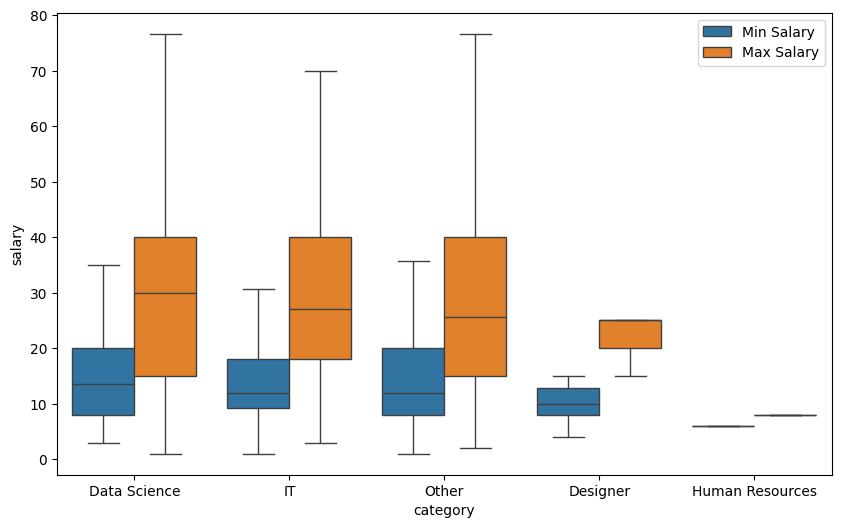

In [128]:
df_salary = df_wrangle.melt(id_vars=['category'], value_vars=['salary_min', 'salary_max'], var_name='salary_type', value_name='salary')
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(df_salary,y = 'salary', x = 'category' ,hue = 'salary_type',ax=ax, showfliers=False)
# change hue name
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Min Salary', 'Max Salary'])
plt.show()

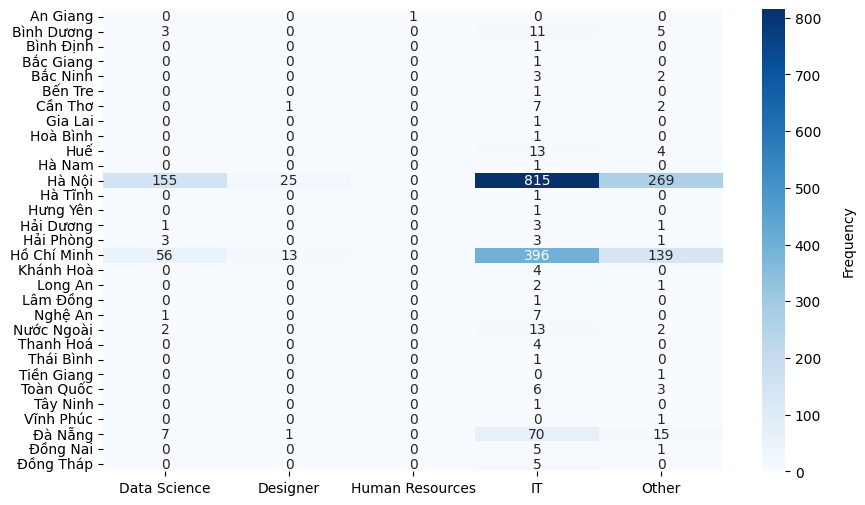

In [129]:
# duplicate the rows to many rows if they having mutiple cities 
df_city = df_wrangle.copy()
df_city['city'] = df_city['city'].str.split(', ')
df_city = df_city.explode('city')
# Compute a simple cross tabulation of two (or more) factors.
city_category_freq = pd.crosstab(index = df_city['city'], columns = df_city['category'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(city_category_freq, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
# set label of the color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Frequency', labelpad=15)
plt.show()

In [ ]:
import pandas as pd
import enchant
from underthesea import word_tokenize
from langdetect import detect

# Initialize English dictionary
english_dict = enchant.Dict("en_US")

def spell_check(text):
    # Split text into words
    tokens = word_tokenize(text) # Tokenize words
    # final = [word for word in final if not english_dict.check(word)]
    try:
        tokens = [word for word in tokens if detect(word) != 'vi' and detect(word) != 'en']
    except:
        tokens = []
    return tokens
df_keyword = df_wrangle.copy()
df_keyword['job_title_keywords'] = df_keyword['job_title'].apply(spell_check)
df_keyword = df_keyword.explode('job_title_keywords')

<Axes: ylabel='job_title_keywords'>

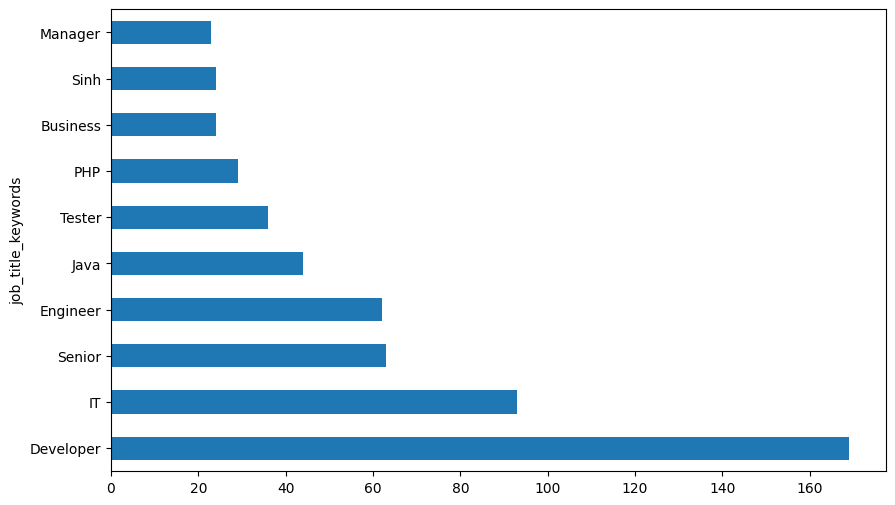

In [133]:
df_keyword['job_title_keywords'].value_counts().head(10).plot(kind='barh', figsize=(10, 6))